In [1]:
!pip install pypulseq==1.3.1.post1 &> /dev/null
!pip install MRzeroCore &> /dev/null
!wget https://github.com/MRsources/MRzero-Core/raw/main/documentation/playground_mr0/numerical_brain_cropped.mat &> /dev/null
!wget https://github.com/MRsources/MRzero-Core/raw/main/documentation/playground_mr0/util.py &> /dev/null

Syntaxfehler.
Syntaxfehler.
Syntaxfehler.
Syntaxfehler.


In [2]:
import numpy as np
# newer numpy versions don't contain this, but pypulseq still relies on it
np.int = int
np.float = float
np.complex = complex

import MRzeroCore as mr0
import pypulseq as pp
import matplotlib.pyplot as plt
import util

plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

experiment_id = 'STE'

(STE_3pulses_5echoes_seq)=
# STE in a brain phantom

In [3]:
# %% S1. SETUP sys
# choose the scanner limits
system = pp.Opts(
    max_grad=28, grad_unit='mT/m', max_slew=150, slew_unit='T/m/s',
    rf_ringdown_time=20e-6, rf_dead_time=100e-6,
    adc_dead_time=20e-6, grad_raster_time=50 * 10e-6
)

In [4]:
#@title STE in a brain phantom - sequence
# %% S2. DEFINE the sequence, FOV and resolution
seq = pp.Sequence()
fov = 220e-3
Nread = 128
Nphase = 1
slice_thickness = 8e-3  # slice

# Define rf events
rf1, _, _ = pp.make_sinc_pulse(
    flip_angle=90 * np.pi / 180, duration=1e-3, phase_offset=90*np.pi/180,
    slice_thickness=slice_thickness, apodization=0.5, time_bw_product=4,
    system=system, return_gz=True
)
rf2, _, _ = pp.make_sinc_pulse(
    flip_angle=90 * np.pi / 180, duration=1e-3,
    slice_thickness=slice_thickness, apodization=0.5, time_bw_product=4,
    system=system, return_gz=True
)
rf3, _, _ = pp.make_sinc_pulse(
    flip_angle=180 * np.pi / 180, duration=1e-3,
    slice_thickness=slice_thickness, apodization=0.5, time_bw_product=4,
    system=system, return_gz=True
)
# rf1 = pp.make_block_pulse(flip_angle=90 * np.pi / 180, duration=1e-3, system=system)

# Define other gradients and ADC events
adc1 = pp.make_adc(num_samples=Nread, duration=20e-3, phase_offset=0 * np.pi / 180, system=system)
adc2 = pp.make_adc(num_samples=Nread, duration=40e-3, phase_offset=0 * np.pi / 180, system=system)
gx = pp.make_trapezoid(channel='x', flat_area=Nread / fov, flat_time=200e-3, system=system)
gx_pre = pp.make_trapezoid(channel='x', area=-gx.area / 2, duration=1e-3, system=system)
gspoil = pp.make_trapezoid(channel='x', area=1000, duration=5e-3, system=system)


# ======
# CONSTRUCT SEQUENCE
# ======
seq.add_block(rf1)
seq.add_block(adc1)
seq.add_block(pp.make_delay(0.005))
seq.add_block(rf2)
seq.add_block(adc2)
# for _ in range(6):
#     seq.add_block(adc2)
seq.add_block(rf3)
seq.add_block(adc2)
seq.add_block(adc2)



d:\repos\MRzero-Core\.venv\Lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
D:\repos\MRzero-Core\python\MRzeroCore\phantom\voxel_grid_phantom.py:146: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(shape, device=self.PD.device) / 2 / self.size,


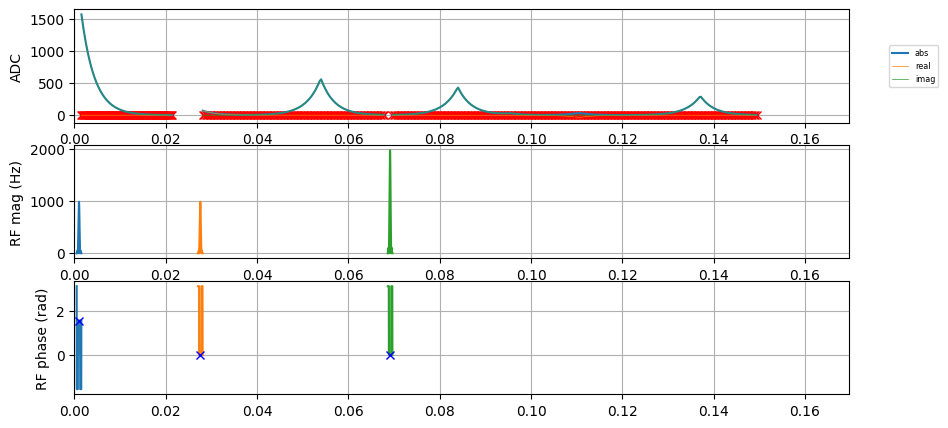

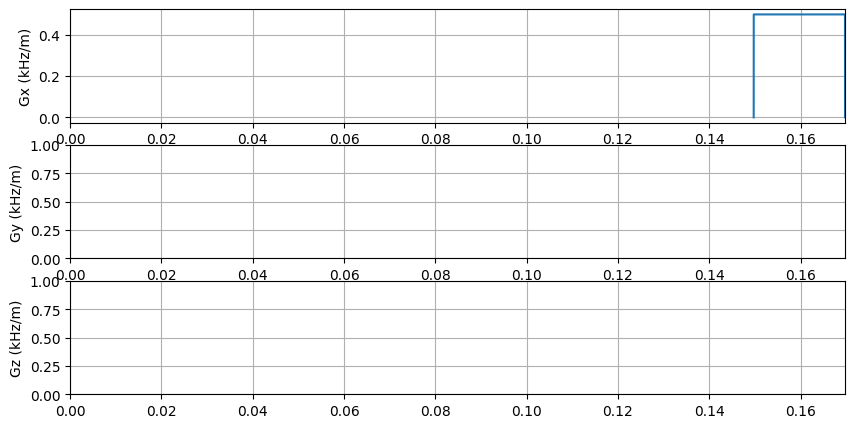

In [5]:
#@title STE in a brain phantom - run
# Bug: pypulseq 1.3.1post1 write() crashes when there is no gradient event
seq.add_block(pp.make_trapezoid('x', duration=20e-3, area=10))

# Prepare the sequence output for the scanner
seq.set_definition('FOV', [fov, fov, slice_thickness])
seq.set_definition('Name', experiment_id)
seq.write(experiment_id + ".seq")

# %% S4: SETUP SPIN SYSTEM/object on which we can run the MR sequence external.seq from above
sz = [64, 64]
obj_p = mr0.VoxelGridPhantom.load_mat('numerical_brain_cropped.mat')
obj_p = obj_p.interpolate(sz[0], sz[1], 1)
# Manipulate loaded data
obj_p.B0 *= 0
obj_p.D *= 0
obj_p.T2dash *= 0.1
#obj_p.plot()
# Convert Phantom into simulation data
obj_p = obj_p.build()

# %% S5:. SIMULATE  the external.seq file and add acquired signal to ADC plot
# Read in the sequence
seq0 = mr0.Sequence.import_file(experiment_id + ".seq")
# seq0.plot_kspace_trajectory()
# Simulate the sequence
graph = mr0.compute_graph(seq0, obj_p, 200, 1e-3)
signal = mr0.execute_graph(graph, seq0, obj_p, print_progress=False)
# PLOT sequence with SIGNAL
sp_adc, t_adc = util.pulseq_plot(seq=seq,signal=signal.numpy())

#plt.figure()
#plt.plot(signal.abs().numpy(),'.')
#plt.show()